<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/NLP/Language_modeling/LSTM_language_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM language modeling

## Imports

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.9 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import re
import string


from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Load dataset

In [5]:
dataset = load_dataset('imdb')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [6]:
dataset['train']['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

## Preprocessing and creating vocab

> Preprocess

> Get vocab or `set` of strings:

  1. split train samples into separate sentences using `sent_tokenize` from `nltk`. Each separate sentence would be a single instance of training samples.

  2. Drop sentences with words num **above** `word_threshold`

  3. Count each word in resulting sentences (Document Frequency). (use `word_tokenize` to split into separate words)

  4. Create `vocab` object of `set`, put `<unk>, <bos>, <eos>, <pad>` and `vocab_size` of the most frequent words.

Get separate sentences and put them in list

In [7]:
word_threshold = 42
stop_words = set(stopwords.words("english"))

In [8]:
def process_article(article, sentences, doc_freq, vocab, word_threshold=32, freq_threshold=10):
  # Tokenize the article into sentences
  token_article = sent_tokenize(article)
  for sentence in token_article:
    sentence = sentence.lower()
    sentence = sentence.replace('<br />', ' ').replace('...', '. ')
    sentence = re.sub(r'[^\w\s]', ' ', sentence)
    token_sentence = word_tokenize(sentence)

    if len(token_sentence) <= word_threshold:
      token_sentence = [word for word in token_sentence if word.isalnum() and word not in stop_words]
      sentences.append(token_sentence)
      words_in_sentence = set(token_sentence)
      for word in words_in_sentence:
        doc_freq[word] += 1
        if doc_freq[word] > freq_threshold:
          vocab.add(word)



In [9]:
sentences = []
doc_freq = Counter()
vocab = {'<unk>', '<bos>', '<eos>', '<pad>'}
vocab_size = 40000

for n in ['train', 'test']:
  for article in tqdm(dataset[n]['text'], desc=f'Processing {n} data'):
    process_article(article, sentences, doc_freq, vocab, 32, 10)

vocab |= {word for word, _ in doc_freq.most_common(vocab_size - len(vocab))}
vocab = list(vocab)[:vocab_size]

Processing train data:   0%|          | 0/25000 [00:00<?, ?it/s]

Processing test data:   0%|          | 0/25000 [00:00<?, ?it/s]

In [10]:
print(f"Sentences total:{len(sentences)}\nVocab len: {len(vocab)}")
for n in range(5):
  print(" ".join(sentences[n]))

Sentences total:439127
Vocab len: 20568
rented curious yellow video store controversy surrounded first released 1967
really sex nudity scenes far even shot like cheaply made porno
countrymen mind find shocking reality sex nudity major staple swedish cinema
curious yellow good film anyone wanting study meat potatoes pun intended swedish cinema
really film much plot


Add vocab_size of the most frequent words into vocab

Bathe in tests

In [11]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab

In [12]:
print("Total words in vocab:", len(vocab))

Total words in vocab: 20568


### Prepare dataset

Create `__getitem__` (return data sample by input idx) in `WordDataset`.

add service tokens for the beginning and the end of sequence and tokenize the sentence using `word_tokenize` and match it with indices from `word2idx`

In [13]:
word2idx = {char: i for i, char in enumerate(vocab)}
idx2word = {i: char for char, i in word2idx.items()}

In [14]:
tags = ['<unk>', '<bos>', '<eos>', '<pad>']

In [29]:
class WordDataset:
  def __init__(self, sent):
    self.data = sent
    self.unk_id, self.bos_id, self.eos_id, self.pad_id  = [word2idx[tag] for tag in tags]

  def __getitem__(self, idx: int) -> List[int]:
    tokenized_sentence = [self.bos_id]
    tokenized_sentence += [word2idx.get(word, self.unk_id) for word in self.data[idx]]
    tokenized_sentence.append(self.eos_id)
    return tokenized_sentence

  def __len__(self) -> int:
    return len(self.data)


In [16]:
def collate_fn_with_padding(input_batch: List[List[int]],
                            pad_id=word2idx['<pad>']) -> torch.Tensor:

    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for seq in input_batch:
        for _ in range(max_seq_len - len(seq)):
            seq.append(pad_id)
        new_batch.append(seq)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {'input_ids': sequences[:,:-1], 'target_ids': sequences[:,1:]}
    return new_batch


In [30]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)

batch_size = 64

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Model architecture and training

In [18]:
class CFG:
  epochs = 6

#### Baseline

In [19]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, vocab_dim, rnn_layers=2, bi=True):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=vocab_dim)
        self.rnn = nn.LSTM(input_size=vocab_dim, hidden_size=vocab_dim, num_layers=rnn_layers, batch_first=True, bidirectional=bi)
        self.fc_1 = nn.Linear(vocab_dim*(bi+1), vocab_dim)
        self.fc_2 = nn.Linear(vocab_dim, vocab_size)

    def forward(self, x):
        embedding = self.embedding(x)
        x, _ = self.rnn(embedding)
        x = torch.tanh(x)
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x

### Evaluation func (1 point)

perplexity is an exponent applied to cross-entropy loss

In [20]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            X = batch["input_ids"]
            logits =model(X)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

#### Plot hist

In [21]:
def plot_loss_and_perp(hist_loss_train, hist_loss_val, hist_perp_train, hist_perp_val):
    epochs = range(1, len(hist_loss_train) + 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist_loss_train, label='Training Loss')
    plt.plot(epochs, hist_loss_val, label='Validation Loss', color='red')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, hist_perp_train, label='Training Perplexity')
    plt.plot(epochs, hist_perp_val, label='Validation Perplexity', color='red')
    plt.title('Perplexity')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Train func (1 point)

In [31]:

def get_epoch(model, optimizer, criterion, epoch, loader, name='Train', scheduler=False):
  if name=='Train':
    model.train()
  else:
    model.eval()
  avg_loss = 0
  avg_perplexity = 0
  for batch in tqdm(loader, desc=f'{name} Epoch: {epoch}'):
    xs, ys = batch['input_ids'].to(device), batch['target_ids'].to(device)
    logits = model(xs)
    loss = criterion(logits.flatten(start_dim=0, end_dim=1), ys.flatten())
    if name=='Train':
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    avg_loss += loss.item()
    avg_perplexity += torch.exp(loss).item()
    if scheduler:
     scheduler.step()
  return avg_loss / len(loader), avg_perplexity / len(loader)


def fit(model, optimizer, criterion, train_loader, eval_loader, scheduler):
  best_perp = np.inf
  best_model = None
  hist_loss_train, hist_loss_val, hist_perp_train, hist_perp_val = [], [], [], []
  for epoch in tqdm(range(CFG.epochs)):
    train_loss, train_perp = get_epoch(model, optimizer, criterion, epoch, train_loader, scheduler=scheduler)
    hist_loss_train.append(train_loss)
    hist_perp_train.append(train_perp)

    val_loss, val_perp = get_epoch(model, optimizer, criterion, epoch, eval_loader, name='Val', scheduler=scheduler)
    hist_loss_val.append(val_loss)
    hist_perp_val.append(val_perp)


    t_loss = round(hist_loss_train[-1], 5)
    v_loss = round(hist_loss_val[-1], 5)
    t_perplexity = round(hist_perp_train[-1], 5)
    v_perplexity = round(hist_perp_val[-1], 5)
    if v_perplexity < best_perp:
      best_model = model.state_dict()

    print('Evaluation perplexity:',evaluate(best_model, criterion, eval_loader))
    print(f"Epoch: {epoch+1}.\n\tTrain loss: {t_loss}\n\ttest_loss: {v_loss}"
          f"\n\ttrain_perplexity: {t_perplexity}\n\ttest_perplexity: {v_perplexity}")
    plot_loss_and_perp(hist_loss_train, hist_loss_val, hist_perp_train, hist_perp_val)

  model.load_state_dict(best_model)
  model.eval()
  return model, (hist_loss_train, hist_loss_val, hist_perp_train, hist_perp_val)

### Func for models

In [33]:
def train_func(model_class, vocab, train_loader, eval_loader, dim_size=256, lr=3e-4):
  model = model_class(len(vocab), dim_size).to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss(ignore_index=word2idx["<pad>"])
  scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8], gamma=0.1)
  best_model, history = fit(model, optimizer, criterion, train_loader, eval_loader, scheduler)
  return best_model, criterion, history

### Experiment 1

  0%|          | 0/6 [00:00<?, ?it/s]

Train Epoch: 0:   0%|          | 0/5490 [00:00<?, ?it/s]

Val Epoch: 0:   0%|          | 0/1373 [00:00<?, ?it/s]

Epoch: 1.
	Train loss: 6.15229
	test_loss: 4.59747
	train_perplexity: 831.93905
	test_perplexity: 101.00495


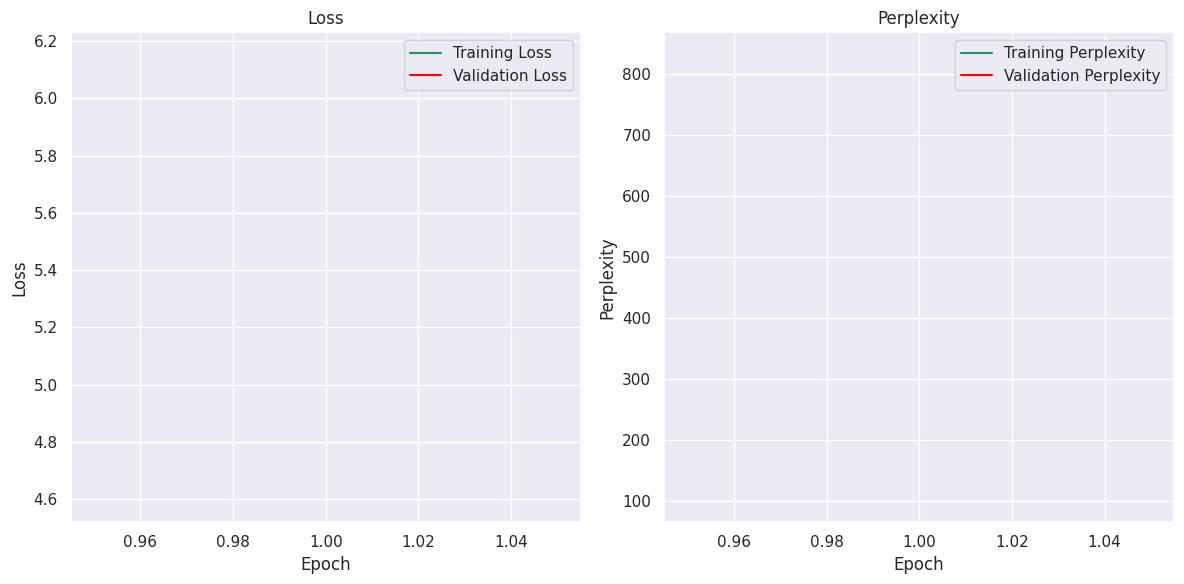

Train Epoch: 1:   0%|          | 0/5490 [00:00<?, ?it/s]

Val Epoch: 1:   0%|          | 0/1373 [00:00<?, ?it/s]

Epoch: 2.
	Train loss: 2.9901
	test_loss: 1.52217
	train_perplexity: 29.9902
	test_perplexity: 4.62485


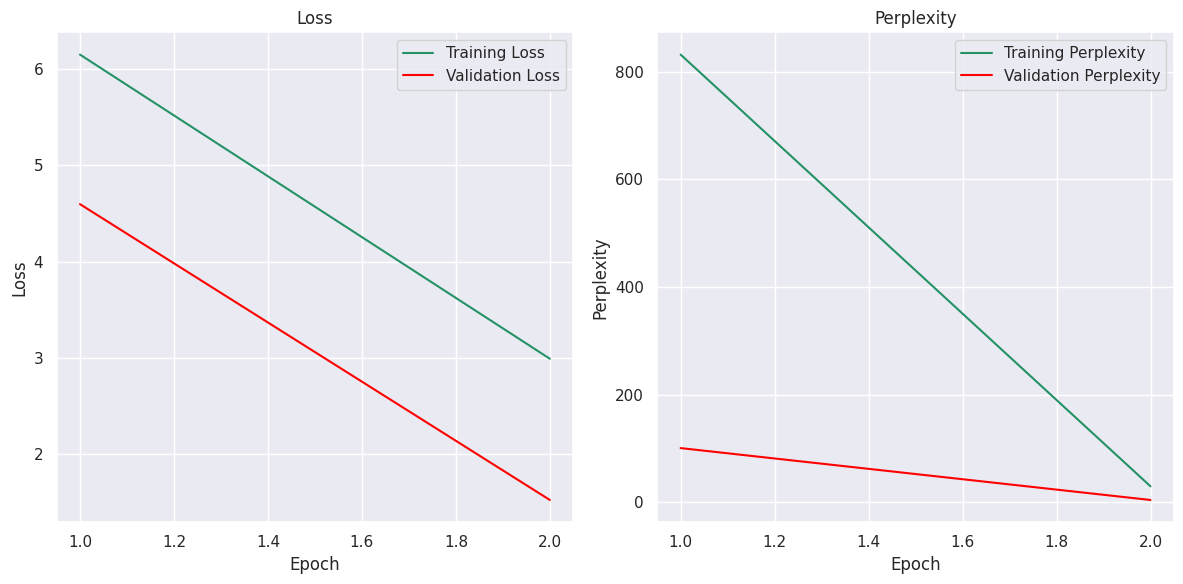

Train Epoch: 2:   0%|          | 0/5490 [00:00<?, ?it/s]

Val Epoch: 2:   0%|          | 0/1373 [00:00<?, ?it/s]

Epoch: 3.
	Train loss: 0.74915
	test_loss: 0.33958
	train_perplexity: 2.25153
	test_perplexity: 1.40625


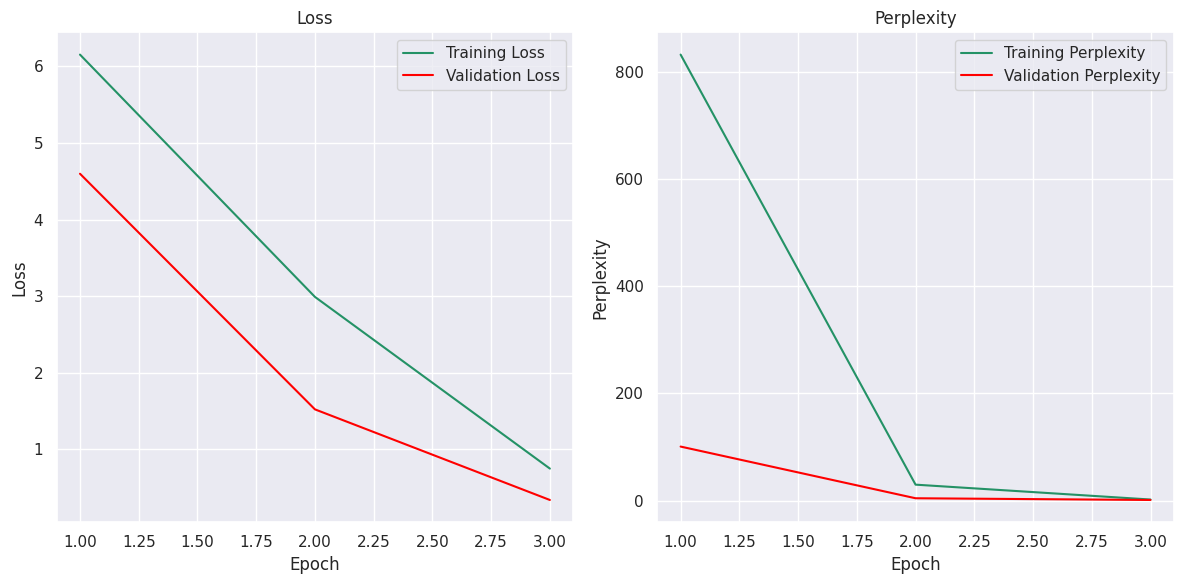

Train Epoch: 3:   0%|          | 0/5490 [00:00<?, ?it/s]

Val Epoch: 3:   0%|          | 0/1373 [00:00<?, ?it/s]

Epoch: 4.
	Train loss: 0.178
	test_loss: 0.10513
	train_perplexity: 1.19772
	test_perplexity: 1.11113


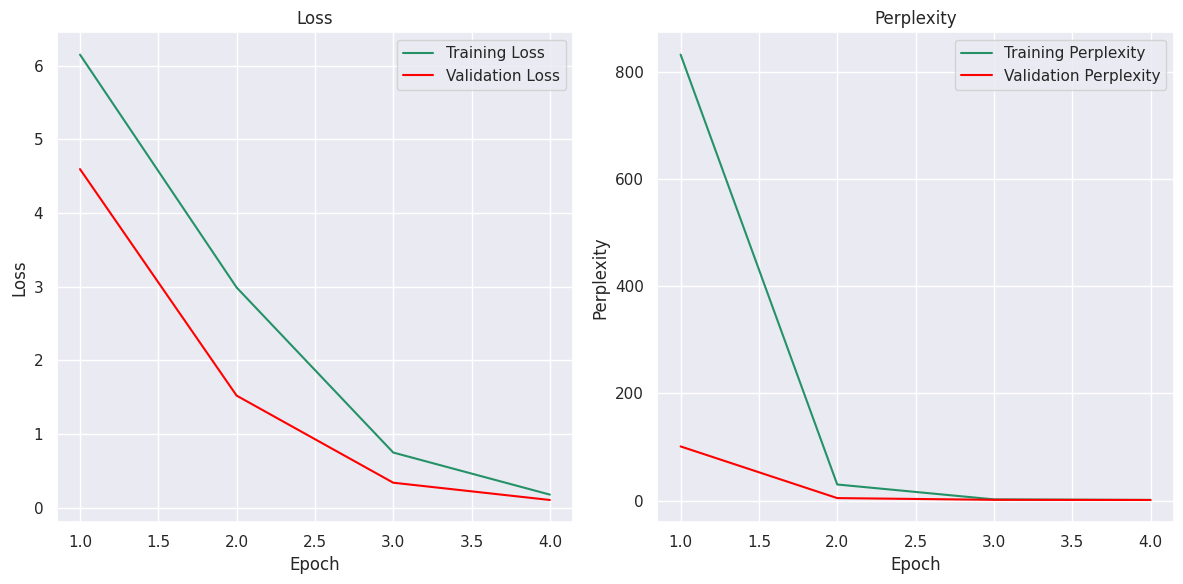

Train Epoch: 4:   0%|          | 0/5490 [00:00<?, ?it/s]

Val Epoch: 4:   0%|          | 0/1373 [00:00<?, ?it/s]

Epoch: 5.
	Train loss: 0.05771
	test_loss: 0.04026
	train_perplexity: 1.05964
	test_perplexity: 1.04114


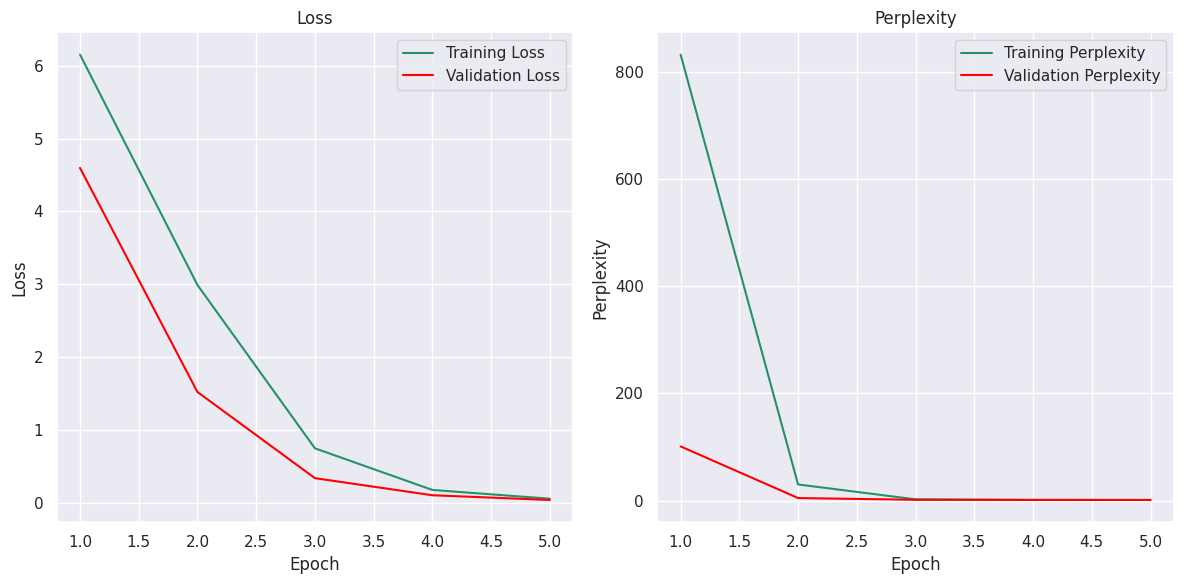

Train Epoch: 5:   0%|          | 0/5490 [00:00<?, ?it/s]

Val Epoch: 5:   0%|          | 0/1373 [00:00<?, ?it/s]

Epoch: 6.
	Train loss: 0.02216
	test_loss: 0.01745
	train_perplexity: 1.02244
	test_perplexity: 1.01762


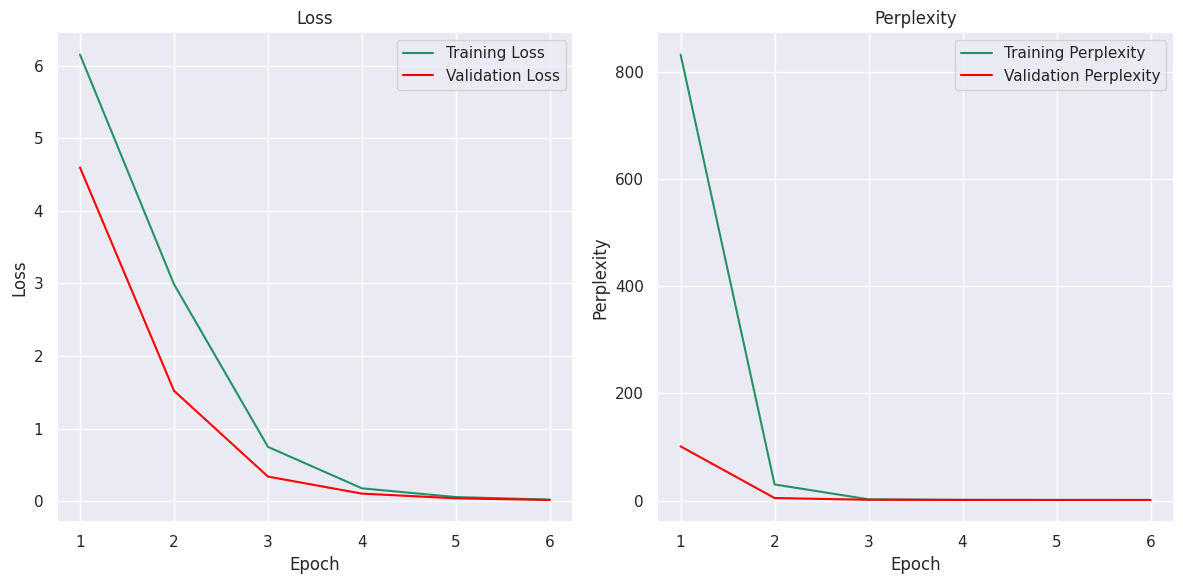

LSTMModel(
  (embedding): Embedding(20568, 256)
  (rnn): LSTM(256, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc_1): Linear(in_features=512, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=20568, bias=True)
)

In [34]:
bset_model, optimizer, criterion, history = train_func(LSTMModel, vocab, train_dataloader, eval_dataloader)